In [1]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [4]:
## If you are using the data by mounting the google drive, use the following :

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [9]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/Sagar/UpGrad/Courses/CNN Model - Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [10]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [11]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### Data Visualisation

Found 2239 files belonging to 9 classes.


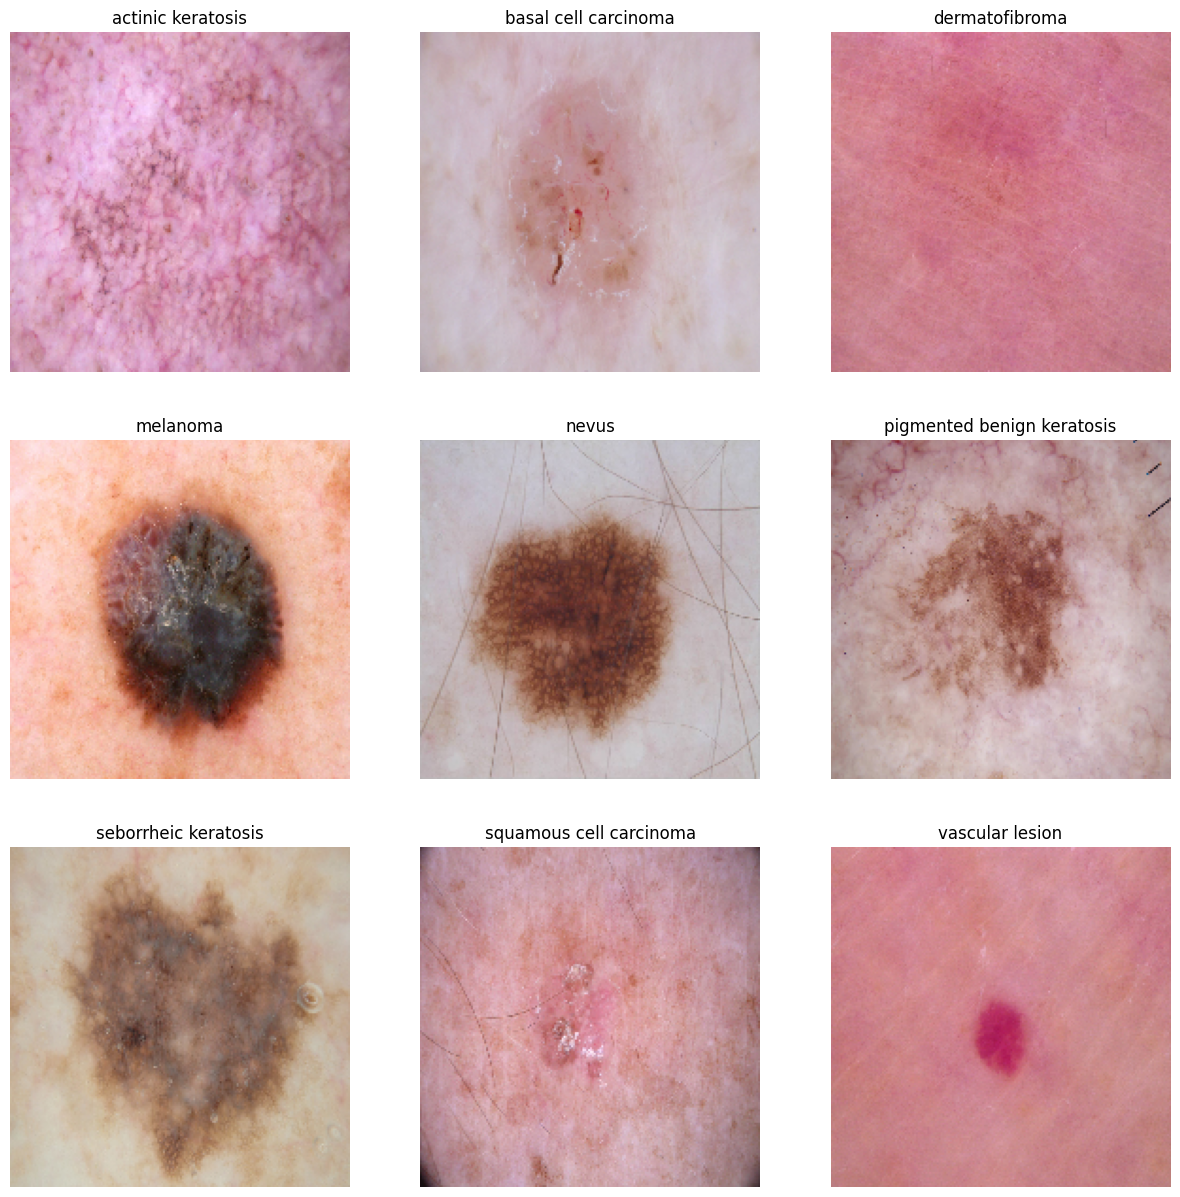

In [12]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

#### Visualize distribution of classes in the training dataset.

In [13]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,squamous cell carcinoma,181
1,vascular lesion,139
2,actinic keratosis,114
3,seborrheic keratosis,77
4,melanoma,438
5,pigmented benign keratosis,462
6,nevus,357
7,dermatofibroma,95
8,basal cell carcinoma,376


<Axes: xlabel='No. of Image', ylabel='Class'>

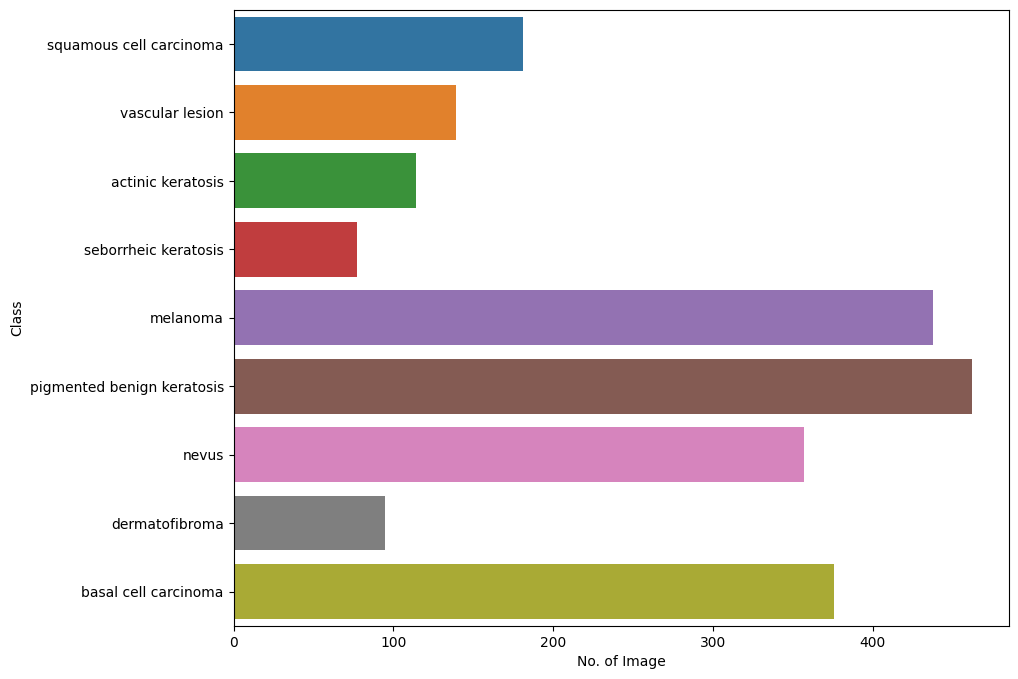

In [14]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

##### There is a class imbalance to solve this using a python package Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [15]:
#install Augmentor
!pip install Augmentor

In [17]:
path_to_training_dataset="/content/gdrive/MyDrive/Sagar/UpGrad/Courses/CNN Model - Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Sagar/UpGrad/Courses/CNN Model - Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ED965550A90>: 100%|██████████| 500/500 [00:20<00:00, 24.13 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Sagar/UpGrad/Courses/CNN Model - Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ED9672F3490>: 100%|██████████| 500/500 [00:22<00:00, 22.18 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Sagar/UpGrad/Courses/CNN Model - Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ED9654AF100>: 100%|██████████| 500/500 [00:21<00:00, 23.06 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Sagar/UpGrad/Courses/CNN Model - Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7ED961BA14E0>: 100%|██████████| 500/500 [01:49<00:00,  4.57 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Sagar/UpGrad/Courses/CNN Model - Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7ED961BEF790>: 100%|██████████| 500/500 [01:47<00:00,  4.67 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Sagar/UpGrad/Courses/CNN Model - Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ED961C17E50>: 100%|██████████| 500/500 [00:21<00:00, 23.60 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Sagar/UpGrad/Courses/CNN Model - Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7ED9654D29B0>: 100%|██████████| 500/500 [00:48<00:00, 10.20 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Sagar/UpGrad/Courses/CNN Model - Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ED9654E93F0>: 100%|██████████| 500/500 [00:23<00:00, 20.91 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Sagar/UpGrad/Courses/CNN Model - Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7ED965505840>: 100%|██████████| 500/500 [00:21<00:00, 22.93 Samples/s]


In [18]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [19]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [20]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [21]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

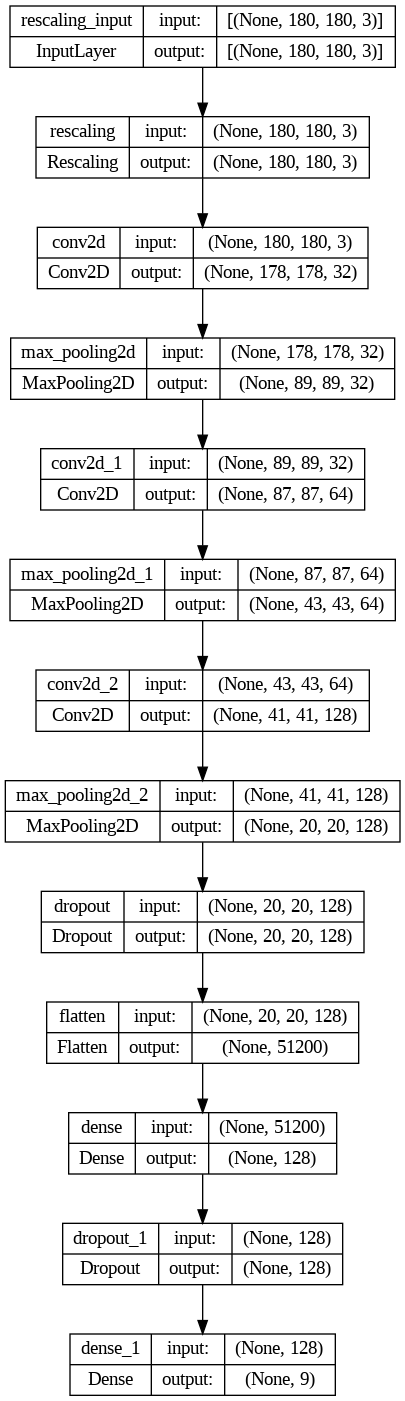

In [23]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [25]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
169/169 [==============================] - ETA: 0s - loss: 1.8392 - accuracy: 0.3023
Epoch 1: val_accuracy improved from -inf to 0.41054, saving model to model.h5
169/169 [==============================] - 405s 2s/step - loss: 1.8392 - accuracy: 0.3023 - val_loss: 1.5569 - val_accuracy: 0.4105


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
169/169 [==============================] - ETA: 0s - loss: 1.4733 - accuracy: 0.4332
Epoch 2: val_accuracy improved from 0.41054 to 0.45509, saving model to model.h5
169/169 [==============================] - 362s 2s/step - loss: 1.4733 - accuracy: 0.4332 - val_loss: 1.4526 - val_accuracy: 0.4551
Epoch 3/20
169/169 [==============================] - ETA: 0s - loss: 1.3328 - accuracy: 0.4915
Epoch 3: val_accuracy improved from 0.45509 to 0.55754, saving model to model.h5
169/169 [==============================] - 376s 2s/step - loss: 1.3328 - accuracy: 0.4915 - val_loss: 1.1983 - val_accuracy: 0.5575
Epoch 4/20
169/169 [==============================] - ETA: 0s - loss: 1.1899 - accuracy: 0.5478
Epoch 4: val_accuracy improved from 0.55754 to 0.60802, saving model to model.h5
169/169 [==============================] - 354s 2s/step - loss: 1.1899 - accuracy: 0.5478 - val_loss: 1.1032 - val_accuracy: 0.6080
Epoch 5/20
169/169 [==============================] - ETA: 0s - loss: 1.0

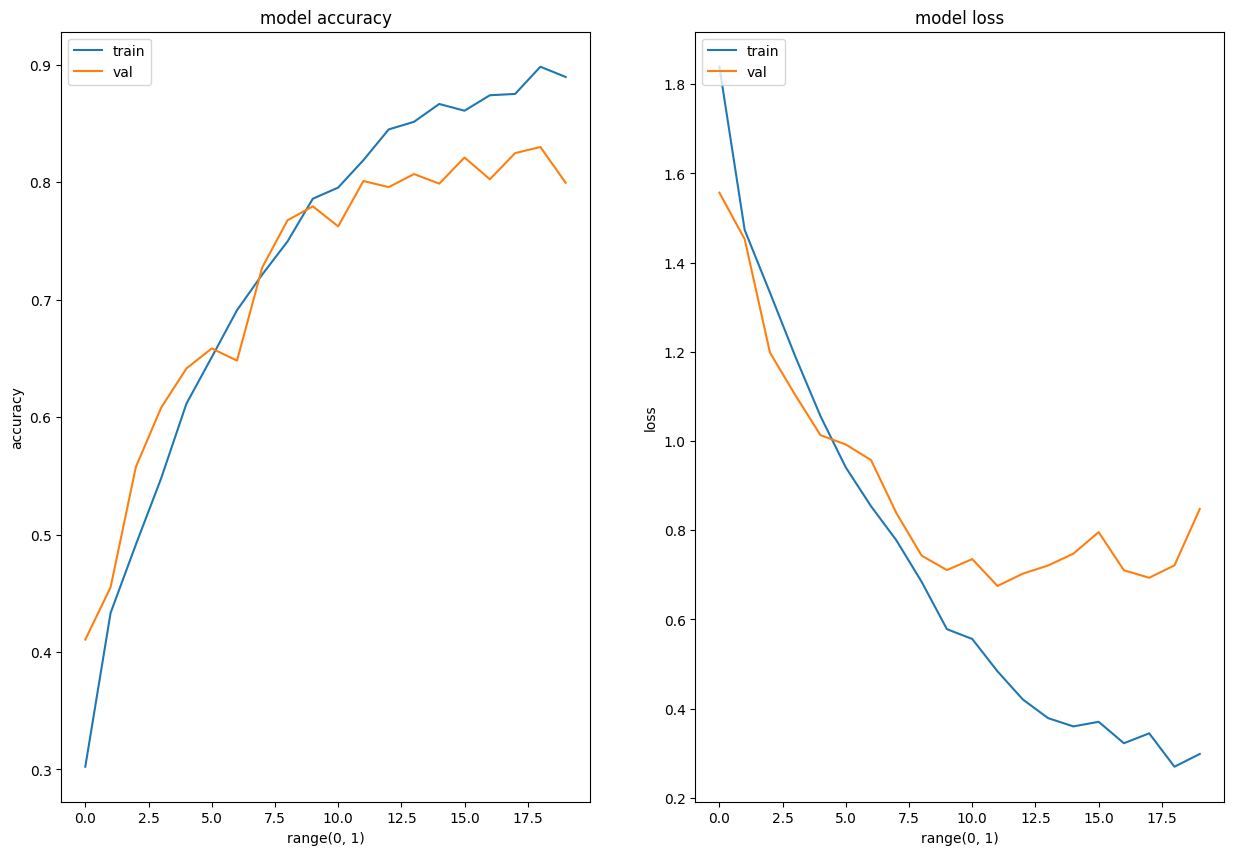

In [26]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Model Prediction

1/1 [==============================] - 0s 59ms/step
Actual Class basal cell carcinoma
Predictive Class actinic keratosis


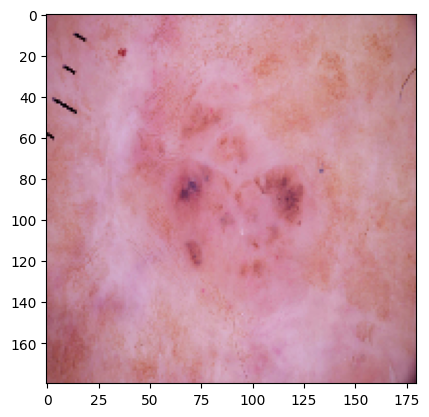

In [28]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )